In [1]:
import sys
import os

# Add the path to the directory where your module is located
module_path = os.path.abspath(os.path.join('..', 'C:\\Users\\pier1\\OneDrive\\Desktop\\uni\\Master\\2.Semester\\Machine Learning (WIWI)\\Project\\Data for depression\\'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import your module
from helpers import *

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from NN import *
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
model, accuracys, precisions, recalls, f1_scores, auc, fprs, tprs, thresholds = [], [], [], [], [], [], [], [], []

Use the models to predict the test data and use the confusion matrix and their metrices (accuracy, precision, recall and f1-score)

Accuracy:  0.9630369630369631
Precision:  0.805111821086262
Recall:  0.7433628318584071
F1:  0.7730061349693252


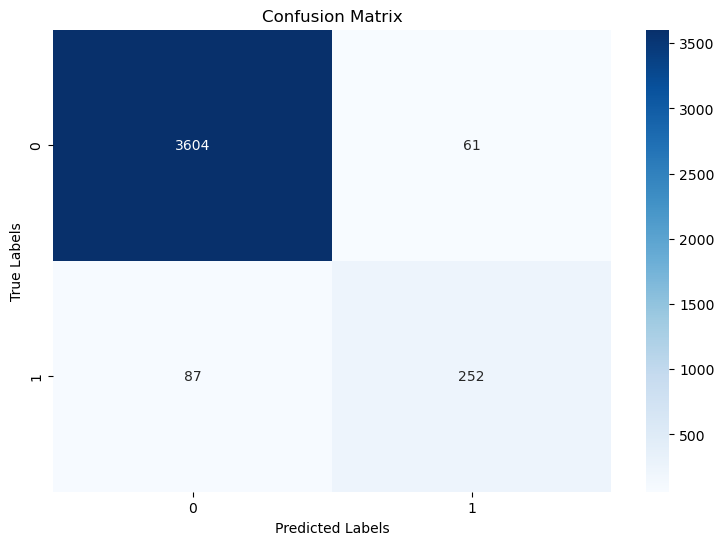

In [4]:
input_size = 56
hidden_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

depression_classifier = 'BP_PHQ_9'
sample_version = 1

model_phq_9 = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_phq_9.load_state_dict(torch.load('Models/BP_PHQ_9.pth'))
model_phq_9.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_phq_9, device, depression_classifier, sample_version)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier + f'_v{sample_version}')
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))
#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

Accuracy:  0.9178180513188587
Precision:  0.883289124668435
Recall:  0.7931269139162981
F1:  0.8357834349229115


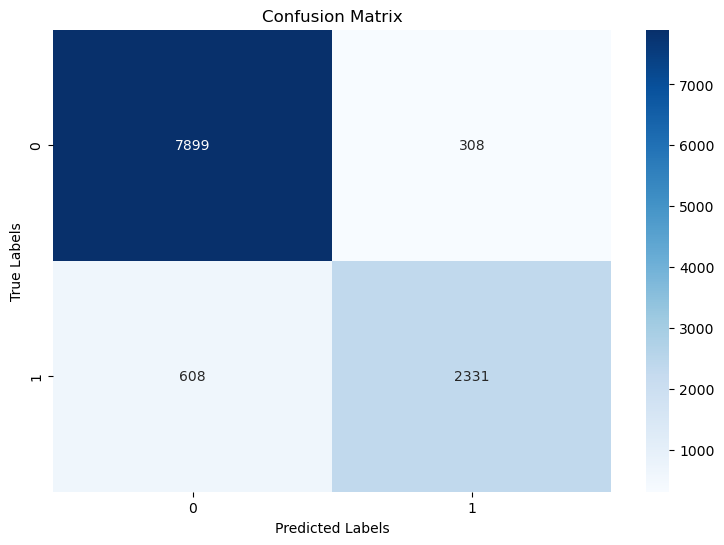

In [5]:
depression_classifier = 'MH_PHQ_S'
sample_version = 1

model_mh_phq_s = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_mh_phq_s.load_state_dict(torch.load('Models/MH_PHQ_S.pth'))
model_mh_phq_s.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_mh_phq_s, device, 'MH_PHQ_S', sample_version)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier + f'_v{sample_version}')
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))

#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

Accuracy:  0.5912408759124088
Precision:  0.5879158180583842
Recall:  0.9897142857142858
F1:  0.737649063032368


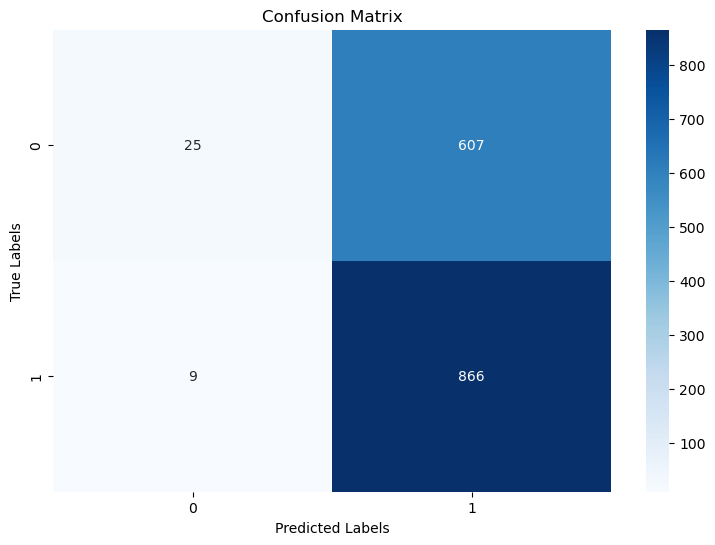

In [6]:
depression_classifier = 'BP_PHQ_9'
sample_version = 2

model_phq_9_v2 = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_phq_9_v2.load_state_dict(torch.load('Models/BP_PHQ_9_v2.pth'))
model_phq_9_v2.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_phq_9_v2, device, 'BP_PHQ_9', sample_version)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier + f'_v{sample_version}')
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))
#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

Accuracy:  0.9328199681359532
Precision:  0.9387755102040817
Recall:  0.9581356980820788
F1:  0.9483568075117371


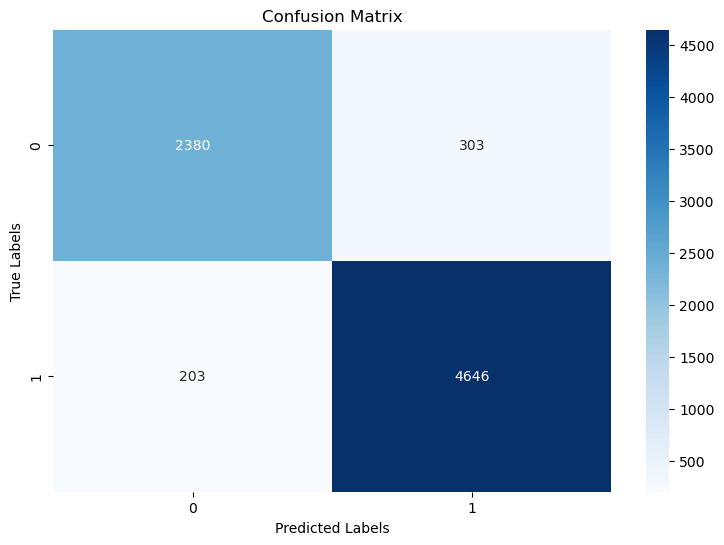

In [7]:
depression_classifier = 'MH_PHQ_S'
sample_version = 2


model_mh_phq_s_v2 = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_mh_phq_s_v2.load_state_dict(torch.load('Models/MH_PHQ_S_v2.pth'))
model_mh_phq_s_v2.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_mh_phq_s_v2, device, 'MH_PHQ_S', sample_version)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier + f'_v{sample_version}')
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))
#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

### Sampling 1
- Best for BP_PHQ_9_v1 is a Depth of 4, with 100 Trees and a Learning Rate of 0.8 (Accuracy 99%)
- Best for MH_PHQ_9_v1 is a Depth of 4, with 100 Trees and a Learning Rate of 1 (Accuracy 90%)
### Sampling 2
- Best for BP_PHQ_9_v2 is a Depth of 4, with 90 Trees and a Learning Rate of 0.3 (Accuracy 97%)
- Best for MH_PHQ_9_v2 is a Depth of 4, with 100 Trees and a Learning Rate of 1 (Accuracy 89%)

Accuracy:  0.99000999000999
Precision:  0.9542682926829268
Recall:  0.9260355029585798
F1:  0.93993993993994
Accuracy:  0.9855144855144855
Precision:  0.9046242774566474
Recall:  0.9260355029585798
F1:  0.915204678362573
Accuracy:  0.9794293297942933
Precision:  0.9707943925233645
Recall:  0.992831541218638
F1:  0.9816893089190787
Accuracy:  0.9714664897146649
Precision:  0.9573732718894009
Recall:  0.992831541218638
F1:  0.9747800586510265


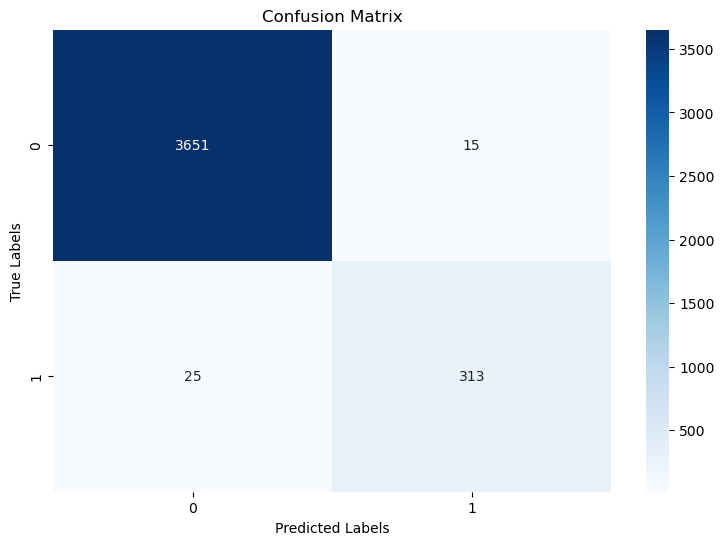

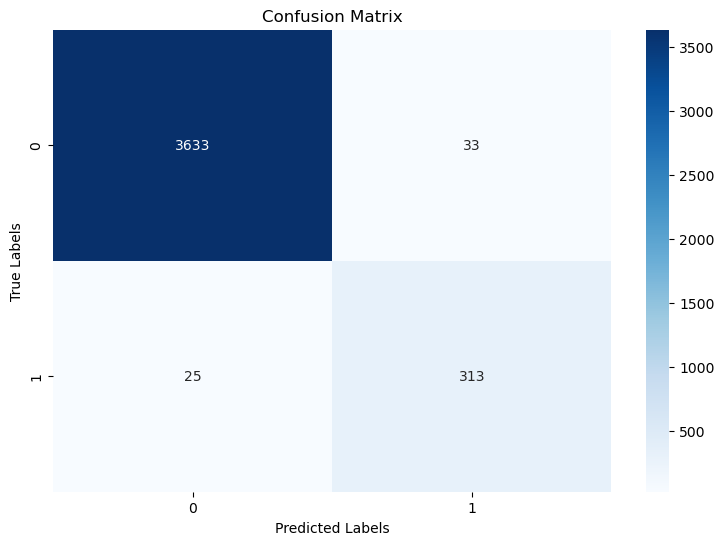

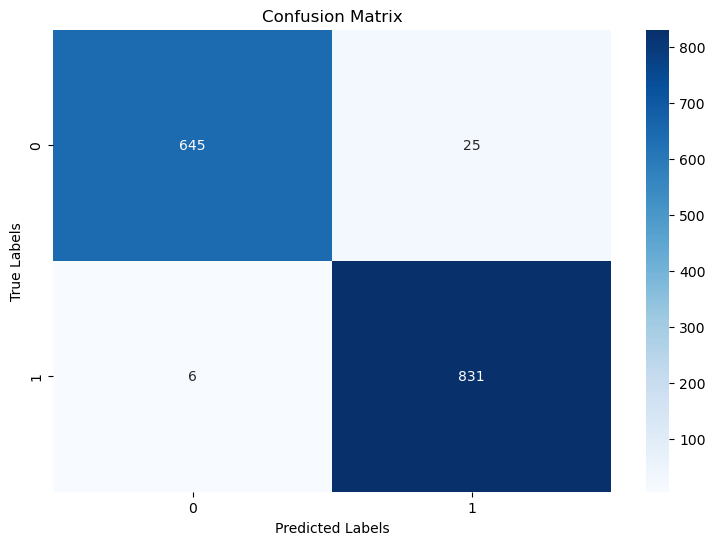

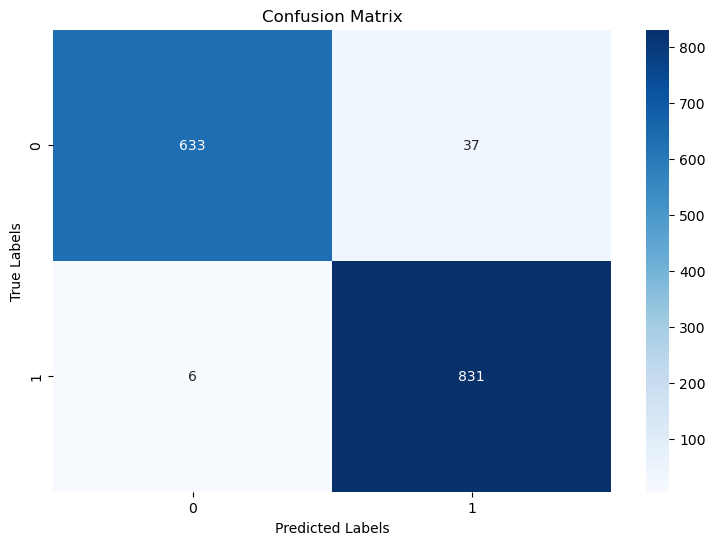

In [8]:
depression_classifiers = ['BP_PHQ_9','MH_PHQ_S', 'BP_PHQ_9', 'MH_PHQ_S']
sample_version = [1,1,2,2]


#Using the optimal hyperparameters to get metrices and scores
learning_rates = [0.8,1,0.3,1]
depth = 4
n_estimators = [100, 100, 90, 100]

for i in range(4):
    if depression_classifiers[i] == 'BP_PHQ_9':
        if sample_version[i] == 1:
            df = pd.read_csv('..\data\Threshold_3_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
        else:
            df = pd.read_csv('..\data\Threshold_3_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2.csv')
    elif depression_classifier[i] == 'MH_PHQ_S':
        if sample_version[i] == 1:
            df = pd.read_csv('..\data\Threshold_10_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')
        else:
            df = pd.read_csv('..\data\Threshold_10_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2.csv')

    features = []
    targets = []
    for indx, row in df.iterrows():
        feature = []
        for column in df.columns:
            if 'FEATURE' in column:
                feature.append(row[column])
        features.append(feature)
        targets.append(row['Depression'])

    features = np.array(features, dtype=np.float32)
    targets = np.array(targets, dtype=np.int16)

    X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.2, random_state=42)

    base_estimator = DecisionTreeClassifier(max_depth=depth)
    ada_boost = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators[i], learning_rate=learning_rates[i], random_state=42)
    ada_boost.fit(X_train, y_train)
    y_pred = ada_boost.predict(X_test)
    predicted_probabilites = ada_boost.predict_proba(X_test)[:,1]

    #Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'Confusion_Matrix/Confusion_Matrix_Adaboost_{depression_classifiers[i]}_v{sample_version[i]}.png')

    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN) # True positive rate
    FNR = FN / (TP + FN) # False negative rate
    f1 = 2 * (precision * recall) / (precision + recall)

    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1: ', f1)
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    model.append('AdaBoost_' + depression_classifiers[i] + f'_v{sample_version[i]}')
    # Compute TPR and FPR
    fpr, tpr, threshold = roc_curve(y_test, predicted_probabilites)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    # Calculate AUC (Area Under the Curve)
    auc.append(roc_auc_score(y_test, predicted_probabilites))
    #auc.append(create_roc(y_pred, predicted_probabilites, depression_classifier, sample_version, model_name='AdaBoost'))
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


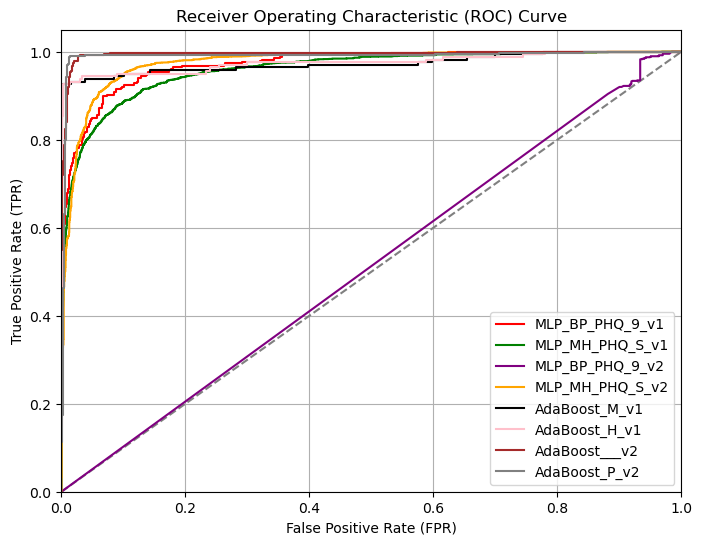

In [9]:
create_roc(fprs, tprs, model)

- The recall is really important here, because we want to detect as many people with depression as possible (TP+FN)
- The F1 Score is important aswell, because of the imbalanced dataset

In [11]:
df = pd.DataFrame({'Model': model, 'Accuracy': accuracys, 'Precision': precisions, 'Recall': recalls, 'F1': f1_scores, 'AUC': auc, 'FPR': fprs, 'TPR': tprs})

In [12]:
print(df)

             Model  Accuracy  Precision    Recall        F1       AUC  \
0  MLP_BP_PHQ_9_v1  0.963037   0.805112  0.743363  0.773006  0.971304   
1  MLP_MH_PHQ_S_v1  0.917818   0.883289  0.793127  0.835783  0.959105   
2  MLP_BP_PHQ_9_v2  0.591241   0.587916  0.989714  0.737649  0.512463   
3  MLP_MH_PHQ_S_v2  0.932820   0.938776  0.958136  0.948357  0.974963   
4    AdaBoost_M_v1  0.990010   0.954268  0.926036  0.939940  0.972877   
5    AdaBoost_H_v1  0.985514   0.904624  0.926036  0.915205  0.975122   
6    AdaBoost___v2  0.979429   0.970794  0.992832  0.981689  0.995299   
7    AdaBoost_P_v2  0.971466   0.957373  0.992832  0.974780  0.990490   

                                                 FPR  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.8813291139240507, 0.8987341772151899, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.